In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering, OPTICS
from sklearn.metrics import silhouette_score
import hdbscan
import time
import pandas as pd
import ast
from scipy.sparse import lil_matrix


print("Loading data...")
df = pd.read_csv("data/clean_data/recipes_cleaned.csv")

# Parse ingredients
if isinstance(df['ingredients_y'].iloc[0], str):
    print("Parsing ingredients_y from string to list...")
    df['ingredients_y'] = df['ingredients_y'].apply(ast.literal_eval)

# Build vocabulary
print("\nBuilding ingredient vocabulary...")
all_ingredients = []
for ing_list in df['ingredients_y']:
    all_ingredients.extend(set(ing_list))

unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n = len(unique_ingredients)

print(f"  Recipes: {len(df)}")
print(f"  Unique ingredients: {n}")

# Build sparse matrix (recipes × ingredients)
print("\nBuilding sparse matrix...")
n_recipes = len(df)
X = lil_matrix((n_recipes, n), dtype=bool)

for r, ing_list in enumerate(df['ingredients_y']):
    unique_in_recipe = set(ing_list)
    for ing in unique_in_recipe:
        X[r, ingredients_index[ing]] = True

X = X.tocsr()  # Convert to CSR for efficient operations
X_ingredients = X.T  # Transpose: (ingredients × recipes)

print(f"  Matrix shape: {X_ingredients.shape}")
print(f"  Memory usage: {X_ingredients.data.nbytes / 1e6:.1f} MB")
print(f"  Sparsity: {1 - X_ingredients.nnz / (X_ingredients.shape[0] * X_ingredients.shape[1]):.4f}") 


print("="*80)
print("ALTERNATIVE CLUSTERING METHODS FOR SPARSE DATA")
print("="*80)

# ============================================================================
# METHOD 1: HIERARCHICAL CLUSTERING (WORKS WELL WITH COSINE DISTANCE)
# ============================================================================

print("\n1. HIERARCHICAL CLUSTERING")
print("-" * 80)

# Use only top N most common ingredients to make it feasible
from scipy.sparse import csr_matrix

# Get ingredient frequencies
ingredient_counts = np.array(X_ingredients.sum(axis=1)).flatten()
top_n = 2000  # Reduce from 14,621 to make it tractable

# Select top ingredients
top_indices = np.argsort(ingredient_counts)[-top_n:]
X_top = X_ingredients[top_indices]
top_ingredients = [unique_ingredients[i] for i in top_indices]

print(f"Using top {top_n} ingredients (by frequency)")

start = time.time()

# Agglomerative clustering with cosine distance
from sklearn.metrics.pairwise import cosine_distances

# Compute distance matrix for top ingredients
print("Computing cosine distance matrix...")
distance_matrix = cosine_distances(X_top)

# Cluster
print("Clustering...")
hierarchical = AgglomerativeClustering(
    n_clusters=None,  # Let it decide
    distance_threshold=0.7,  # Adjust this
    metric='precomputed',
    linkage='average'
)

labels_hier = hierarchical.fit_predict(distance_matrix)
time_hier = time.time() - start

n_clusters_hier = len(set(labels_hier))
print(f"\n✓ Time: {time_hier:.1f}s")
print(f"  Clusters found: {n_clusters_hier}")

# Evaluate
if n_clusters_hier > 1:
    sil_hier = silhouette_score(distance_matrix, labels_hier, metric='precomputed')
    print(f"  Silhouette score: {sil_hier:.3f}")

# Save
np.save('labels_hierarchical.npy', labels_hier)

# ============================================================================
# METHOD 2: HDBSCAN (DENSITY-BASED, HANDLES NOISE WELL)
# ============================================================================

print("\n2. HDBSCAN (DENSITY-BASED)")
print("-" * 80)

# Reduce dimensions first (HDBSCAN works better in lower dimensions)
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

print("Reducing to 100 dimensions for HDBSCAN...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced_hdb = normalize(svd.fit_transform(X_ingredients))

start = time.time()

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,  # Minimum ingredients per cluster
    min_samples=5,
    metric='euclidean',
    cluster_selection_epsilon=0.5,
    core_dist_n_jobs=-1
)

labels_hdb = clusterer.fit_predict(X_reduced_hdb)
time_hdb = time.time() - start

n_clusters_hdb = len(set(labels_hdb)) - (1 if -1 in labels_hdb else 0)
n_noise = np.sum(labels_hdb == -1)

print(f"\n✓ Time: {time_hdb:.1f}s")
print(f"  Clusters found: {n_clusters_hdb}")
print(f"  Noise points: {n_noise} ({n_noise/len(labels_hdb)*100:.1f}%)")

# Evaluate (excluding noise)
mask = labels_hdb != -1
if np.sum(mask) > 100 and len(set(labels_hdb[mask])) > 1:
    sample_idx = np.random.choice(np.where(mask)[0], min(3000, np.sum(mask)), replace=False)
    sil_hdb = silhouette_score(X_reduced_hdb[sample_idx], labels_hdb[sample_idx])
    print(f"  Silhouette score (no noise): {sil_hdb:.3f}")

# Save
np.save('labels_hdbscan.npy', labels_hdb)

# ============================================================================
# METHOD 3: OPTICS (ALTERNATIVE DENSITY-BASED)
# ============================================================================

print("\n3. OPTICS (DENSITY-BASED ALTERNATIVE)")
print("-" * 80)

# Use same reduced data
start = time.time()

optics = OPTICS(
    min_samples=10,
    max_eps=2.0,
    metric='euclidean',
    cluster_method='xi',
    n_jobs=-1
)

labels_opt = optics.fit_predict(X_reduced_hdb)
time_opt = time.time() - start

n_clusters_opt = len(set(labels_opt)) - (1 if -1 in labels_opt else 0)
n_noise_opt = np.sum(labels_opt == -1)

print(f"\n✓ Time: {time_opt:.1f}s")
print(f"  Clusters found: {n_clusters_opt}")
print(f"  Noise points: {n_noise_opt} ({n_noise_opt/len(labels_opt)*100:.1f}%)")

# Evaluate
mask_opt = labels_opt != -1
if np.sum(mask_opt) > 100 and len(set(labels_opt[mask_opt])) > 1:
    sample_idx = np.random.choice(np.where(mask_opt)[0], min(3000, np.sum(mask_opt)), replace=False)
    sil_opt = silhouette_score(X_reduced_hdb[sample_idx], labels_opt[sample_idx])
    print(f"  Silhouette score (no noise): {sil_opt:.3f}")

# Save
np.save('labels_optics.npy', labels_opt)

# ============================================================================
# METHOD 4: GRAPH-BASED CLUSTERING
# ============================================================================

print("\n4. GRAPH-BASED CLUSTERING (RECOMMENDED)")
print("-" * 80)

from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering

# Build k-NN graph (ingredients connected if they co-occur frequently)
print("Building k-nearest neighbors graph...")
start = time.time()

# Use top 2000 ingredients to make it tractable
connectivity = kneighbors_graph(
    X_top, 
    n_neighbors=10, 
    mode='connectivity',
    metric='cosine',
    include_self=False,
    n_jobs=-1
)

# Spectral clustering on the graph
print("Performing spectral clustering...")
spectral = SpectralClustering(
    n_clusters=50,  # Adjust based on desired granularity
    affinity='precomputed',
    assign_labels='discretize',
    random_state=42,
    n_jobs=-1
)

labels_spec = spectral.fit_predict(connectivity)
time_spec = time.time() - start

n_clusters_spec = len(set(labels_spec))

print(f"\n✓ Time: {time_spec:.1f}s")
print(f"  Clusters found: {n_clusters_spec}")

# Evaluate
if n_clusters_spec > 1:
    # Use original cosine distance
    sil_spec = silhouette_score(distance_matrix, labels_spec, metric='precomputed')
    print(f"  Silhouette score: {sil_spec:.3f}")

# Save
np.save('labels_spectral.npy', labels_spec)

# ============================================================================
# COMPARISON OF ALL METHODS
# ============================================================================

print("\n" + "="*80)
print("FINAL COMPARISON")
print("="*80)

print(f"\n{'Method':<25} {'Clusters':<12} {'Silhouette':<12} {'Time (s)'}")
print("-" * 80)
print(f"{'K-Means (Full)':<25} {148:<12} {-0.503:<12.3f} {10.6:.1f}")
print(f"{'Hierarchical (top 2k)':<25} {n_clusters_hier:<12} {sil_hier:<12.3f} {time_hier:.1f}")
print(f"{'HDBSCAN':<25} {n_clusters_hdb:<12} {sil_hdb if 'sil_hdb' in locals() else 'N/A':<12} {time_hdb:.1f}")
print(f"{'OPTICS':<25} {n_clusters_opt:<12} {sil_opt if 'sil_opt' in locals() else 'N/A':<12} {time_opt:.1f}")
print(f"{'Spectral':<25} {n_clusters_spec:<12} {sil_spec:<12.3f} {time_spec:.1f}")


Loading data...
Parsing ingredients_y from string to list...

Building ingredient vocabulary...
  Recipes: 222705
  Unique ingredients: 14621

Building sparse matrix...
  Matrix shape: (14621, 222705)
  Memory usage: 2.0 MB
  Sparsity: 0.9994
ALTERNATIVE CLUSTERING METHODS FOR SPARSE DATA

1. HIERARCHICAL CLUSTERING
--------------------------------------------------------------------------------
Using top 2000 ingredients (by frequency)
Computing cosine distance matrix...
Clustering...

✓ Time: 0.2s
  Clusters found: 1978
  Silhouette score: 0.003

2. HDBSCAN (DENSITY-BASED)
--------------------------------------------------------------------------------
Reducing to 100 dimensions for HDBSCAN...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✓ Time: 14.6s
  Clusters found: 67
  Noise points: 12840 (87.8%)
  Silhouette score (no noise): 0.349

3. OPTICS (DENSITY-BASED ALTERNATIVE)
--------------------------------------------------------------------------------

✓ Time: 29.1s
  Clusters found: 47
  Noise points: 13790 (94.3%)
  Silhouette score (no noise): 0.586

4. GRAPH-BASED CLUSTERING (RECOMMENDED)
--------------------------------------------------------------------------------
Building k-nearest neighbors graph...
Performing spectral clustering...


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:309: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)



✓ Time: 0.7s
  Clusters found: 50
  Silhouette score: 0.006

FINAL COMPARISON

Method                    Clusters     Silhouette   Time (s)
--------------------------------------------------------------------------------
K-Means (Full)            148          -0.503       10.6
Hierarchical (top 2k)     1978         0.003        0.2
HDBSCAN                   67           0.34855928899841726 14.6
OPTICS                    47           0.5860657493954835 29.1
Spectral                  50           0.006        0.7

RECOMMENDATION

✓ For ingredient clustering, use:
  1. HDBSCAN - Best for finding natural groups + handling noise
  2. Spectral Clustering - Best for co-occurrence patterns
  3. Hierarchical - Best if you want a dendrogram/taxonomy

✗ Avoid K-Means for this type of data (negative silhouette!)


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



POST-CLUSTER ANALYSIS

=== INTERPRETING CLUSTERS (HDBSCAN) ===
Non-noise clusters: 67
Cluster size range: 10 – 269

Sample of top ingredients per cluster:
  Cluster   0: diced onion, diced onions, red onions, spanish onion, sweet onion, sweet onions, vidalia onion, white onion, white onions, yellow onion
  Cluster   1: artichoke dip, asiago caesar salad dressing, stove top low-sodium chicken stuffing mix, shake-n-bake, salt-free fajita seasoning mix, parmesan and mozzarella pasta sauce, low-carb milk, low fat biscuits, lipton recipe secrets savory herb with garlic soup mix, kraft hickory smoked barbecue sauce
  Cluster   2: cantonese roast pork, cavolo nero, chicken broth, cuitlacoche, fat-free breakfast sausage, fried rice with vegetables, frozen mixed peas carrots and potatoes, honey glaze mix, lentil and vegetable soup, pork shanks
  Cluster   3: basil, dill, low-carb marinara sauce, marjoram, oregano, rosemary, rusks, sage, savory, summer savory
  Cluster   4: fat free peppercorn 

/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


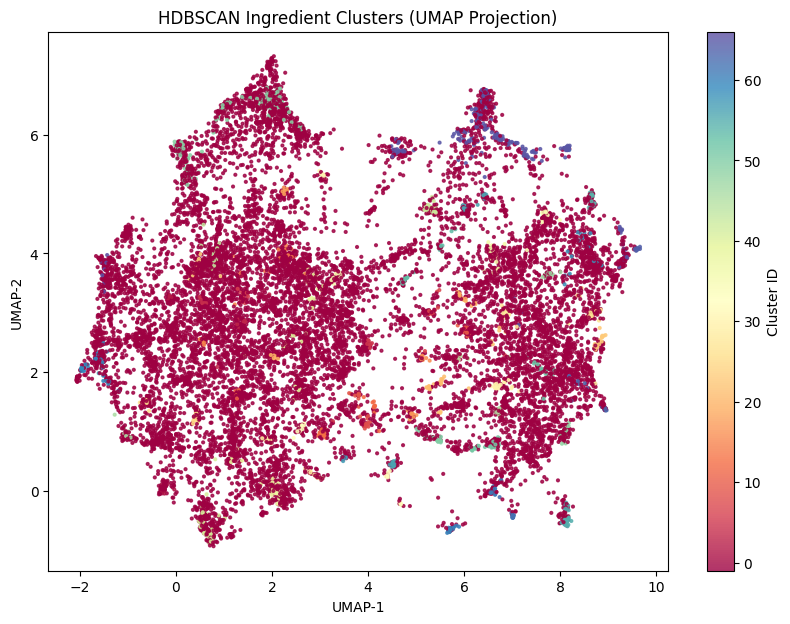


=== ADDITIONAL CLUSTER METRICS ===
Calinski–Harabasz Index: 55.031
Davies–Bouldin Index: 1.157

✓ Exported ingredient clusters to ingredient_clusters.csv
✓ Exported top ingredients per cluster to cluster_summary.csv


"\n💡 Optimization notes:\n1. Filter rare ingredients before building X_ingredients (e.g., keep those in ≥10 recipes)\n2. Use TruncatedSVD(200) instead of 100 for slightly richer structure\n3. Cache UMAP results for reuse: np.save('umap_embedding.npy', embedding)\n"

In [ ]:
# =============================================================================
# CLUSTER ANALYSIS & VISUALIZATION
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from umap import UMAP

print("\n" + "="*80)
print("POST-CLUSTER ANALYSIS")
print("="*80)

# Choose which clustering to analyze (default: HDBSCAN)
labels = labels_hdb
cluster_method_name = "HDBSCAN"

# Optional: Switch here if you want to inspect OPTICS or Spectral
# labels = labels_opt
# cluster_method_name = "OPTICS"
# labels = labels_spec
# cluster_method_name = "Spectral"

ingredient_names = unique_ingredients
X_reduced = X_reduced_hdb  # 100D reduced data used in HDBSCAN & OPTICS

# ---------------------------------------------------------------------------
# 1CLUSTER INTERPRETATION
# ---------------------------------------------------------------------------
print(f"\n=== INTERPRETING CLUSTERS ({cluster_method_name}) ===")

ingredient_clusters = pd.DataFrame({
    "ingredient": ingredient_names,
    "cluster": labels
})

valid_clusters = ingredient_clusters[ingredient_clusters.cluster != -1]
cluster_sizes = valid_clusters["cluster"].value_counts().sort_index()
print(f"Non-noise clusters: {len(cluster_sizes)}")
print(f"Cluster size range: {cluster_sizes.min()} – {cluster_sizes.max()}")

def top_ingredients_per_cluster(df, n=10):
    cluster_summary = {}
    for c, sub in df.groupby("cluster"):
        cluster_summary[c] = sub["ingredient"].value_counts().head(n).index.tolist()
    return cluster_summary

cluster_summary = top_ingredients_per_cluster(valid_clusters, n=10)

print("\nSample of top ingredients per cluster:")
for cid, ingredients in list(cluster_summary.items())[:5]:
    print(f"  Cluster {cid:>3}: {', '.join(ingredients)}")

# ---------------------------------------------------------------------------
# VISUALIZATION (UMAP)
# ---------------------------------------------------------------------------
print("\n=== UMAP VISUALIZATION ===")

umap_model = UMAP(n_neighbors=30, min_dist=0.1, metric="cosine", random_state=42)
embedding = umap_model.fit_transform(X_reduced)

plt.figure(figsize=(10, 7))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=labels,
    s=4,
    cmap="Spectral",
    alpha=0.8
)
plt.colorbar(label="Cluster ID")
plt.title(f"{cluster_method_name} Ingredient Clusters (UMAP Projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

# ---------------------------------------------------------------------------
# ADDITIONAL METRICS
# ---------------------------------------------------------------------------
print("\n=== ADDITIONAL CLUSTER METRICS ===")

mask = labels != -1
if np.sum(mask) > 100 and len(set(labels[mask])) > 1:
    X_valid = X_reduced[mask]
    labels_valid = labels[mask]
    ch_score = calinski_harabasz_score(X_valid, labels_valid)
    db_score = davies_bouldin_score(X_valid, labels_valid)
    print(f"Calinski–Harabasz Index: {ch_score:.3f}")
    print(f"Davies–Bouldin Index: {db_score:.3f}")
else:
    print("Not enough valid clusters for CH/DB metrics.")

# ---------------------------------------------------------------------------
# EXPORT RESULTS
# ---------------------------------------------------------------------------
ingredient_clusters.to_csv("ingredient_clusters.csv", index=False)
print("\n Exported ingredient clusters to ingredient_clusters.csv")

summary_df = pd.DataFrame([
    {"cluster": cid, "top_ingredients": ", ".join(ings)}
    for cid, ings in cluster_summary.items()
])
summary_df.to_csv("cluster_summary.csv", index=False)
print(" Exported top ingredients per cluster to cluster_summary.csv")




=== UMAP VISUALIZATION OF HDBSCAN CLUSTERS ===


/Users/duybeobn1/miniconda/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



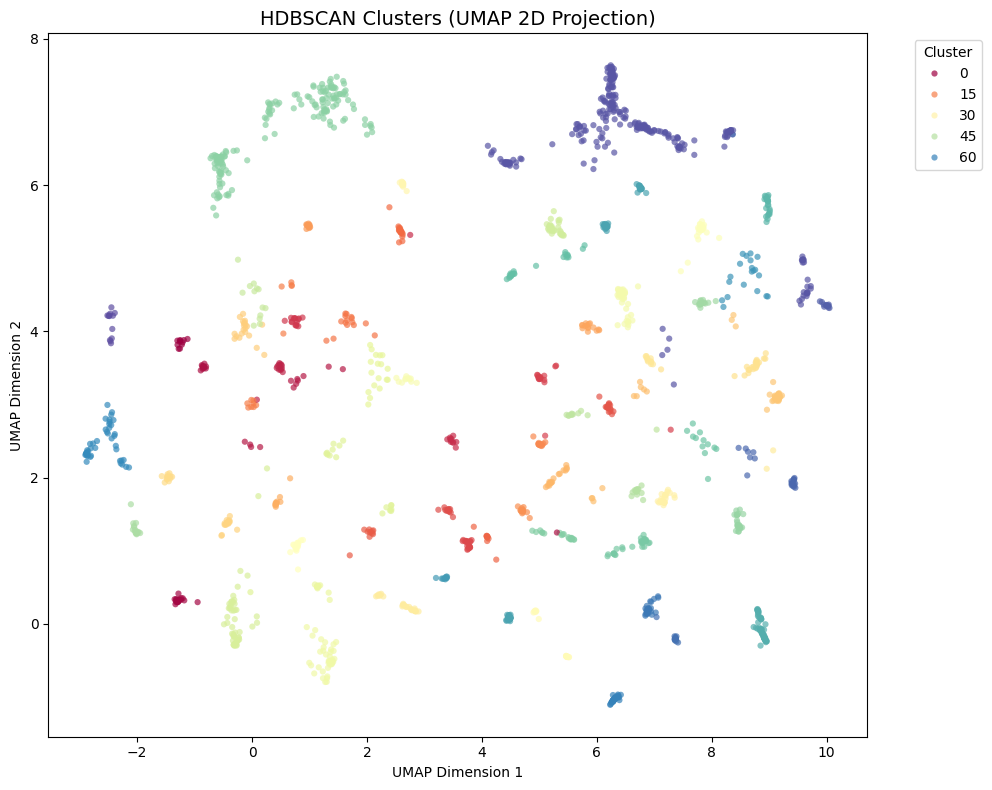

In [14]:
# === VISUALIZE HDBSCAN CLUSTERS IN 2D (UMAP SCATTER) ===
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

# Assuming you have your HDBSCAN reduced data from:
# X_reduced_hdb  → (ingredients × 100) after SVD + normalization
# labels_hdb     → HDBSCAN cluster labels

print("\n=== UMAP VISUALIZATION OF HDBSCAN CLUSTERS ===")

# Reduce to 2D with UMAP
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)
embedding = umap_model.fit_transform(X_reduced_hdb)

# Convert to DataFrame
import pandas as pd
df_umap = pd.DataFrame({
    'x': embedding[:, 0],
    'y': embedding[:, 1],
    'cluster': labels_hdb
})

# Filter out noise for clarity
df_clusters = df_umap[df_umap['cluster'] != -1]

# --------------------------------------------------
# 1️⃣ Static scatterplot
# --------------------------------------------------
plt.figure(figsize=(10, 8))
palette = sns.color_palette('Spectral', as_cmap=True)
sns.scatterplot(
    data=df_clusters,
    x='x', y='y',
    hue='cluster',
    palette='Spectral',
    s=20, linewidth=0, alpha=0.7
)
plt.title("HDBSCAN Clusters (UMAP 2D Projection)", fontsize=14)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# 2️⃣ Interactive Plotly scatter
# --------------------------------------------------
fig = px.scatter(
    df_clusters,
    x='x', y='y',
    color='cluster',
    color_continuous_scale='Spectral',
    hover_data={'x': False, 'y': False, 'cluster': True},
    title="Interactive UMAP Visualization of HDBSCAN Clusters"
)
fig.update_traces(marker=dict(size=6, opacity=0.8))
fig.update_layout(
    width=900, height=700,
    template='plotly_white',
    showlegend=True
)
fig.show()
